In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts
from numpy import random as rnd
from pylcp.common import progressBar
import pandas as pd
import magpylib as mg
import numpy.random 
import magpylib as magpy

In [157]:
cts.hbar

1.0545718176461565e-34

In [158]:
def v_avg(m,T):
    return np.sqrt(8*cts.k*T/(np.pi*m))

In [159]:
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v_a = v_avg(mass_lab,216.85)
sd_M = np.sqrt(cts.k*216.85/mass_lab)


klab = 2*np.pi*25068.2222
# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
Blab = -67*1e-3#(v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
b_0L =  48*1e-3
# (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')/2
# T # About 15 G/cm is a typical gradient for Rb
L = 16
x0 = 1/klab  # cm
t0 = 1/gammalab  # s
#100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) +5
print(Blab, L,b_0L)

-0.067 16 0.048


In [160]:
def mag(R,B_0,alpha,l):
    if R[2] > l:
       return  np.array([0,0,0])
    else:
        return np.array([0,B_0 +alpha*(np.sqrt(1-R[2]/l)),0])

In [161]:
zeeman_prof = magpy.Collection()
j = 30
n = 8
a = 0# distance it circles aroundthe center 
c = 30 #angle of first bar
d =  24#angle of second bar
b = -190# distnace the two section of the array are apart from each other
k = -100 #the first and second magnent are apart
e = 40
l = -5
p= -20# distance the thrid and 4th magnet are apart from each other
m  = -42
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k")
)
angles = np.linspace(0, 360, n, endpoint=False)
for i in angles:
    cube1= magpy.magnet.Cuboid(
    dimension=(6,6,125),
    polarization=(-(1.080),0,0),
    position=(70+a+l,0,140+k))
    cube2 = magpy.magnet.Cuboid(dimension= (4,4,25),
    polarization=(-1.17,0,0),
    position=(60+a+l,0,50+e),style_magnetization = mystyle)
    cube3= magpy.magnet.Cuboid(
    dimension=(6,6,125),
    polarization=(1.08,0,0),
    position=(91.5+m,0,320+b))
 
#     cube5 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(90+a+p+m,0,190))

#     cube6 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(80+a+p+m,0,200),
# )
   


    cube1.rotate_from_angax(i, 'z')
    cube1.rotate_from_angax(c, 'y',)
    cube1.rotate_from_angax(i, 'z', anchor=0)
 
 
    cube2.rotate_from_angax(i, 'z',anchor = 0)
    cube2.rotate_from_angax(i, 'z')
    cube3.rotate_from_angax(i, 'z', anchor=0)
    cube3.rotate_from_angax(-d, 'y')
    cube3.rotate_from_angax(i, 'z')
  
    #cube4.rotate_from_angax(i, 'z', anchor=0)
    #cube4.rotate_from_angax(-d, 'y')
    #cube4.rotate_from_angax(i, 'z')
    

    zeeman_prof.add(cube1)
    zeeman_prof.add(cube2)
    zeeman_prof.add(cube3)
    #zeeman_prof.add(cube4)
    # zeeman_prof.add(cube5)
    # zeeman_prof.add(cube6)
    j = j+1


tfmot = magpy.Collection()
N = 4
angles = np.linspace(0,360,N,endpoint=False)
pol = [0,180,0,180]
l = 35
halbach = magpy.Collection()
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k"),
)
for a in range(len(angles)):
    cube= magpy.magnet.Cuboid(
    dimension=(8,6,80),
    polarization=(1.17,0,0),
    position=(30+l,0,230),
    style_magnetization = mystyle)
    print(a)
    cube.rotate_from_angax(angles[a], 'z',anchor = 0)
    cube.rotate_from_angax(pol[a], 'z')

    tfmot.add(cube)

b_tot = magpy.Collection()
b_tot.add(zeeman_prof,tfmot,override_parent=True)
b_tot.show()


0
1
2
3


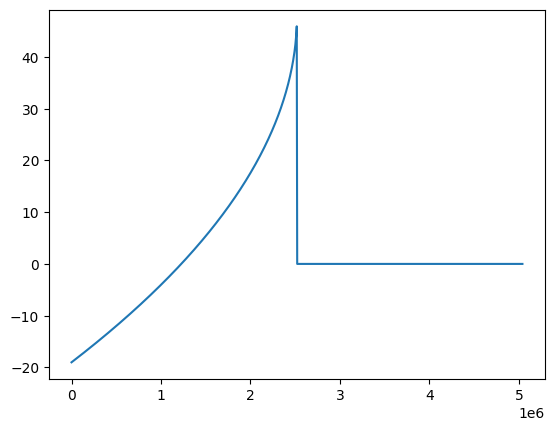

In [162]:
x= np.linspace(0,2*L,1000)/x0
r = []
for i in x:
    r.append(np.array([0,0,i])*x0)
magg = []
for i in r:
    magg.append(mag(i,b_0L,Blab,L)[1])
plt.plot(x,np.array(magg)*1e3)


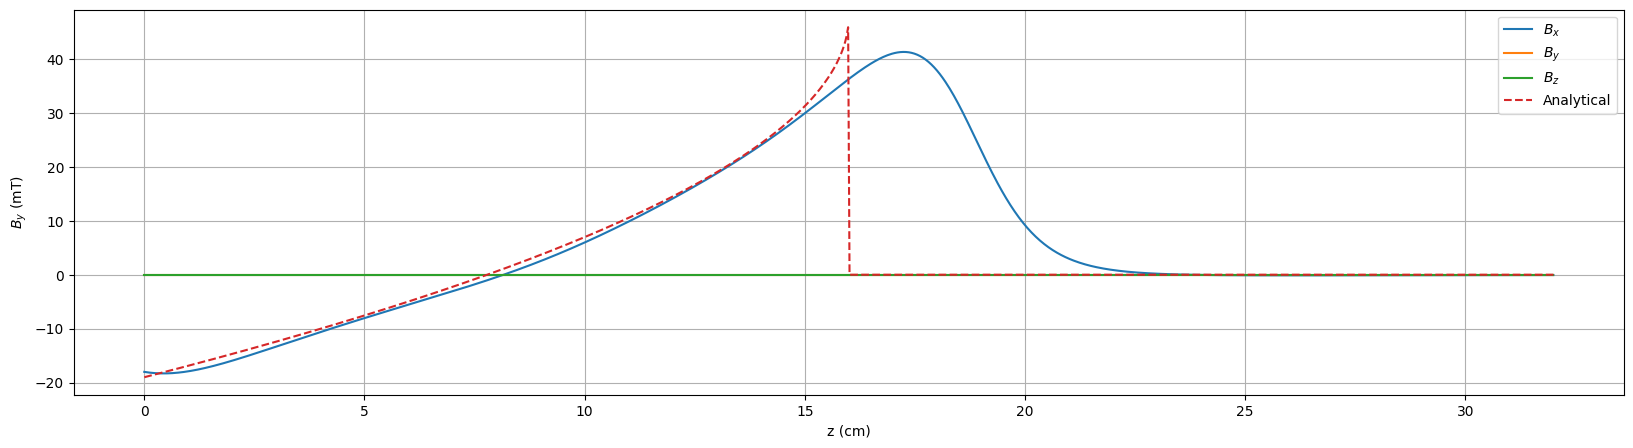

In [163]:
z = np.linspace(0,2*L,1000)
b_y = []
b_z = []
b_x = []
for i in z:
    b_x.append(zeeman_prof.getB([0,0,i*10])[0])
    b_y.append(zeeman_prof.getB([0,0,i*10])[1])
    b_z.append(zeeman_prof.getB([0,0,i*10])[2])

fig,ax = plt.subplots(1,1,figsize=(20,5))    
plt.plot(z,np.array(b_x)*1e3)
plt.plot(z,np.array(b_y)*1e3)
plt.plot(z,np.array(b_z)*1e3)
#plt.yticks([-20,0,20,40])
#plt.xticks([-0.1,0,0.1,0.2,0.3,0.4])
plt.xlabel('z (cm)')
plt.plot(x*x0,np.array(magg)*1e3, '--')

plt.ylabel('$B$ (mT)')
plt.legend(['$B_x$','$B_y$','$B_z$','Analytical'])  
plt.ylabel('$B_y$ (mT)')
plt.grid()

In [164]:
zeeman_prof.getB([0,0,0])[0]*1e3

-18.007209902695763

In [165]:
b_z_P = [x for x in b_z if x > 0]
k = z[b_z.index(min(b_z_P))]
print(k)


25.56156156156156


In [166]:
def sat(wavenumber, gamma):

    wavelength = 1 / (wavenumber * 100)
    
    # Saturation intensity formula
    return np.pi * cts.c* cts.h * gamma / (3 * wavelength**3)

wavenumber = 25068.222  # Wavenumber in cm^-1
gamma = 1.93e8  # Decay rate in s^-1
Isat = sat(wavenumber, gamma)
print(Isat)
Isat*7*(((4*1e-3)**2)*np.pi)*1e3


632.4602794347063


222.53644756665514

In [167]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # cm
t0 = 1/gammalab  # s

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
b_0 = cts.value('Bohr magneton')*b_0L*t0/cts.hbar 
l = L/x0 

print(x0, t0, mass, k, gamma, alpha,b_0)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 -30.52874111941582 21.871336921372524


In [168]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)
det_1 = np.linspace(0,-20,100)
vc = x0/t0*1/(100)
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)

bf = lambda R: cts.value('Bohr magneton')*b_tot.getB(R*10*x0)*t0/cts.hbar
laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0, 0, -1]), 's': 10,'pol_coord':'spherical', 'pol': np.array([1, 0,1]), 'delta': (E_e_D2[2]-E_g_D2[0]) + -25*gamma},],
    beam_type=pylcp.infinitePlaneWaveBeam) 
linGrad = pylcp.magField(lambda R: bf(R))


In [169]:
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)


In [170]:
force_profiles = {}
det = np.linspace(0,-30,100)
j = 0
b = 0
#for i in det: 
j = j+1  
laserBeams = pylcp.laserBeams([
{'kvec':np.array([0, 0, -1]), 's': s,'pol_coord':'spherical', 'pol': np.array([1, 0,1]), 'delta': (E_e_D2[2]-E_g_D2[0]) + -25*gamma},],
beam_type=pylcp.infinitePlaneWaveBeam) 
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)
x = np.arange(0, 2*L, 0.4)/(x0)
v = np.arange(0, 600,15)/vc


X, V = np.meshgrid(x, v)

Rvec = np.array([np.zeros(X.shape), np.zeros(X.shape), X])
Vvec = np.array([np.zeros(V.shape), np.zeros(V.shape), V])

rateeq.generate_force_profile(Rvec, Vvec, name='Fz', progress_bar=True)

force_profiles[f'{j}'] = rateeq.profile['Fz'].F[2]

b = b +1
print(b)


ValueError: Unable to find solution at r=(0.00,0.00,3024159.08) and v=(0.00,0.00,15.91)

C:\Users\benfo\AppData\Local\Temp\ipykernel_33796\1330495898.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Text(0.5, 1.0, 'Contour plot of position vs velocity and force')

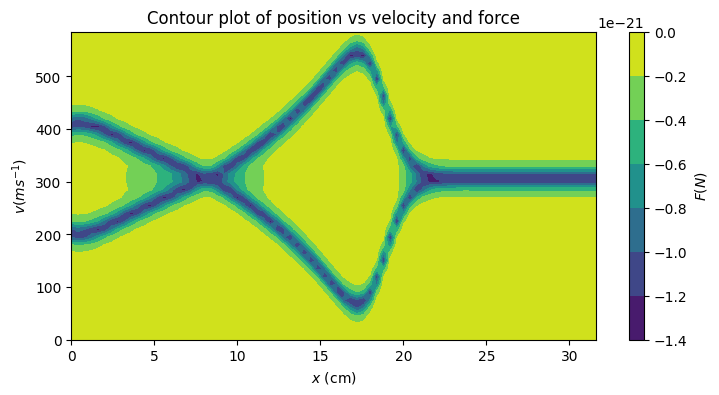

In [ ]:
Fc = cts.hbar*klab*gammalab
fig,ax = plt.subplots(1, 1, figsize=(8, 4)) 
cmap_reversed = plt.cm.get_cmap('viridis_r')
Fc = gammalab*cts.hbar*klab
im1 = ax.contourf(np.array(x)*x0, np.array(v)*vc, rateeq.profile['Fz'].F[2]*Fc)
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$F(N)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v (ms^{-1})$')
plt.title('Contour plot of position vs velocity and force')

code below plots dynamics directly from pylcp  found this was too slow

In [ ]:
# fig,ax = plt.subplots(1,2, figsize=(8,4))
# ax[0].plot(rateeq.sol.t*t0*1e3,rateeq.sol.r[0]*x0)
# ax[1].plot(rateeq.sol.t*t0*1e3,rateeq.sol.v[0]*vc)
# ax[0].set_xlabel('t (ms)')
# ax[0].set_ylabel('z (cm)')
# ax[1].set_xlabel('t (ms)')
# ax[1].set_ylabel('v (m/s)')
# ax[1].yticks = np.arange(0, 200, 100)
# plt.tight_layout()

In [ ]:
# import numpy as np

# # Assuming vc, v0, t0, rateeq, etc., are defined elsewhere in your code

# sol_v = []
# sol_r = []
# sol_t = []
# t_span = [0, 0.0013/t0]  # Define the time span for the evolution
# j = 0

# # Generate velocities with a normal distribution
# velocities = np.random.normal(v0, 10, 100)
# rounded_velocities = np.round(velocities, 3) / vc  # Round and normalize velocities

# # Define a reasonable velocity threshold to avoid extreme cases
# velocity_threshold = 10 * v0  # You can adjust this threshold

# for i in range(100):  # Loop over 100 atoms
#     print(j)

#     # Check if the velocity is within a reasonable range
#     if np.abs(velocities[i]) > velocity_threshold:
#         print(f"Skipping atom {j} due to extreme velocity: {velocities[i]}")
#         j += 1
#         continue

#     try:
#         # Set initial velocity and position for rate equations
    #     rateeq.v0 = np.array([rounded_velocities[i], 0., 0.])  # x-velocity only
    #     rateeq.r0 = [0, 0, 0]  # Initial position

    #     # Set the initial population in the Hamiltonian
    #     n0 = np.zeros(rateeq.hamiltonian.n)
    #     n0[0] = 1  # Assume initial population in ground state
    #     rateeq.set_initial_pop(n0)

    #     # Evolve the motion over the time span
    #     rateeq.evolve_motion(t_span,
    #                          progress_bar=True,
    #                          random_recoil=False)

    #     # Append the resulting velocity and position to the solution lists
    #     sol_v.append(rateeq.sol.v[0])
    #     sol_r.append(rateeq.sol.r[0]) 
    #      # Append final velocity in x-direction
    #     sol_t.append(rateeq.sol.t)  # Append final position in x-direction

    # except Exception as e:
    #     print(f"Error evolving atom {j}: {e}")  # Handle any evolution errors

    # j += 1
    



done with suvat this was faster 

In [ ]:
def find_nearest_value(lst, target):
    nearest = min(lst, key=lambda x: abs(x - target))
    return nearest

In [ ]:
t_max = 0.005/t0 
t_span = np.linspace(0,t_max,1000)
x_t = []
v_t = []
v_0 =350/vc
v_t_y = 10/vc
v_t_z = 10/vc
v_ind = list(np.array(v))
x_ind = list(np.array(x))
s  = 0
di = 0
dt = 0 
for i in range(len(t_span)):
    dt = t_span[i] - di
    
    c = v_ind.index(find_nearest_value(v_ind,v_0))

    d = x_ind.index(find_nearest_value(x_ind,s))

    a = ((rateeq.profile['Fz'].F[2][c][d]))/mass

    s = (1/2)*a*(dt**2) + v_0*dt + s

    v_0 = v_0 + a*dt

    x_t.append(s)

    v_t.append(v_0) 

    di = t_span[i]


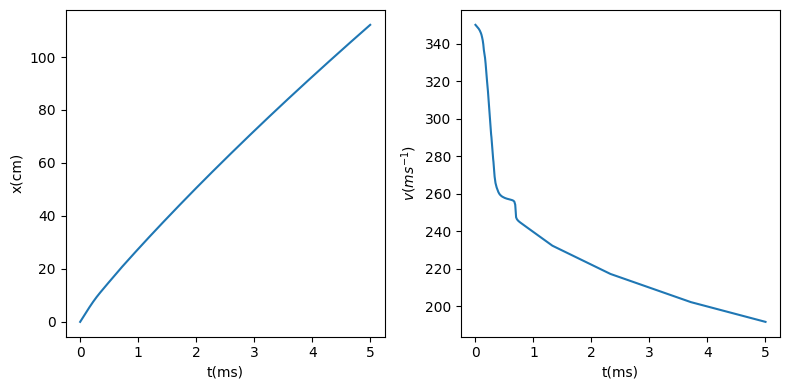

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(np.array(t_span)*t0*1e3,np.array(x_t)*x0)
ax[0].set_xlabel('t(ms)')
ax[0].set_ylabel('x(cm)')
ax[1].plot(np.array(t_span)*t0*1e3,np.array(v_t)*vc)
ax[1].set_xlabel('t(ms)')
ax[1].set_ylabel('v(ms^-1)')
ax[1].set_ylabel('$v(ms^{-1})$')
plt.tight_layout()

In [ ]:
# this defines a radom point on a sphere to dfine randdom recoil making sim more accurate
def random_sphere(u,theta):
    x =np.sqrt(1-u**2)*np.cos(theta)
    y =np.sqrt(1-u**2)*sin(theta)
    z = u
    return [x,y,z]
    


In [ ]:
def sd(t,m):
    return np.sqrt((cts.k*t/m)*((8/np.pi) - 1))


In [ ]:
    # how to add random recoil
capture_efficnecy1 = []
capture_efficnecy2 = []
random_recoil = 'no'
sd_yb = sd(216.85, mass_lab)
velocitiesz = np.random.normal(v_a,sd_yb, 100) 
v_s_t = v_a*35e-3
v_sd = (max(velocitiesz)*35e-3)/3
velocitiest = np.random.normal(v_s_t,v_sd, 100)
force_profilesx = {}
force_profilesx['1'] = force_profiles['1']
b = 0
for key in force_profiles:
        z_n  = []
        vz_n = []
        x_n =  []
        y_n =  []
        for j in range(len(velocitiesz)):   
            t_max = 0.0010/t0
            t_span = np.linspace(0,t_max,10000)
            z_t = []
            v_t = []
            y_t = []
            x_t = []
            v_0z = velocitiesz[j]/vc
            v_0y = velocitiest[j]
            v_0x = velocitiest[j] 
            v_ind = list(np.array(v))
            x_ind = list(np.array(x))
            sz = 0
            sx = 0
            sy = 0
            di = 0
            dt  =  0 
            for i in range(len(t_span)):
                dt = t_span[i] - di
                
                c = v_ind.index(find_nearest_value(v_ind,v_0))

                d = x_ind.index(find_nearest_value(x_ind,sz))

                a = ((force_profiles[key][c][d]))/mass

                sz = (1/2)*a*(dt**2) + v_0z*dt + sz
                if random_recoil == 'yes':
                    recoil = dt*(a)*random_sphere(np.random.uniform(-1,1),np.random.uniform(0,2*np.pi))
                else: 
                    recoil = [0,0,0]
                v_0z = v_0z + a*dt - recoil[2]

                sx = sx + v_0x*(dt*t0) - recoil[0]

                sy = sy + v_0y*(dt*t0) - recoil[1]

                z_t.append(sz)

                x_t.append(sx)

                y_t.append(sy)
                
                v_t.append(v_0z)
                    
                di = t_span[i]

            z_n.append(z_t)
            x_n.append(x_t)
            y_n.append(y_t)
            vz_n.append(v_t) 
    
            l = 26/x0
            qw = 0
            q = 0 
            for m in range(len(vz_n)):
                K = vz_n[m]
                if int(K[0]) > 0:
                    z_pp = z_n[m]
                    pos = K[z_pp.index(find_nearest_value(z_pp,l))]
                    if pos < 9.6:
                        q = q + 1
                    elif pos < 50:
                        qw = qw + 1

            
    capture_efficnecy1.append(q)
    capture_efficnecy2.append(qw)
    b = b+1
    print(q)   
    print(qw)       
    print(f'number at:{b}')           

NameError: name 'force_profiles' is not defined

In [ ]:
max(capture_efficnecy2)

61

<>:4: SyntaxWarning:

invalid escape sequence '\G'

<>:6: SyntaxWarning:

invalid escape sequence '\G'

<>:4: SyntaxWarning:

invalid escape sequence '\G'

<>:6: SyntaxWarning:

invalid escape sequence '\G'

C:\Users\benfo\AppData\Local\Temp\ipykernel_20456\1616850147.py:4: SyntaxWarning:

invalid escape sequence '\G'

C:\Users\benfo\AppData\Local\Temp\ipykernel_20456\1616850147.py:6: SyntaxWarning:

invalid escape sequence '\G'



Text(0, 0.5, 'Capture Efficiency(<9.6)')

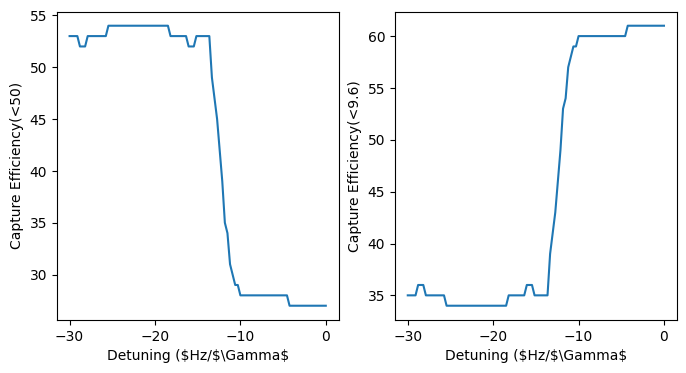

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(det,capture_efficnecy1)
ax[1].plot(det,capture_efficnecy2)
ax[0].set_xlabel('Detuning ($Hz/$\Gamma$')
ax[0].set_ylabel('Capture Efficiency(<50)')
ax[1].set_xlabel('Detuning ($Hz/$\Gamma$')
ax[1].set_ylabel('Capture Efficiency(<9.6)')

In [ ]:
l = 27/x0
c = 0   
capture_efficnecy = []

for  m in range(len(vz_n)):
        K = vz_n[m]
        if int(K[0]) > 0:
            z_pp = z_n[m]
            pos = K[z_pp.index(find_nearest_value(z_pp,l))]
            if pos < 9.6:
                c = c + 1
print(c)

9


-12.525252525252526

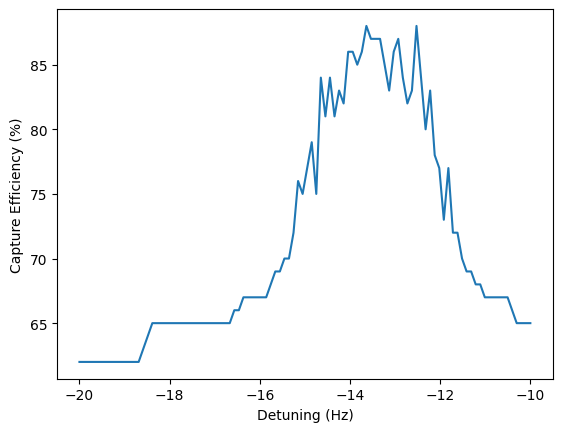

In [ ]:
det = np.linspace(-10,-20,100)
plt.plot(det*gamma, capture_efficnecy)
plt.xlabel('Detuning (Hz)')
plt.ylabel('Capture Efficiency (%)')
capture_efficnecy.index(max(capture_efficnecy))
det[25]*gammalab/1e6
det[25]*gamma


Text(0, 0.5, 'y (cm)')

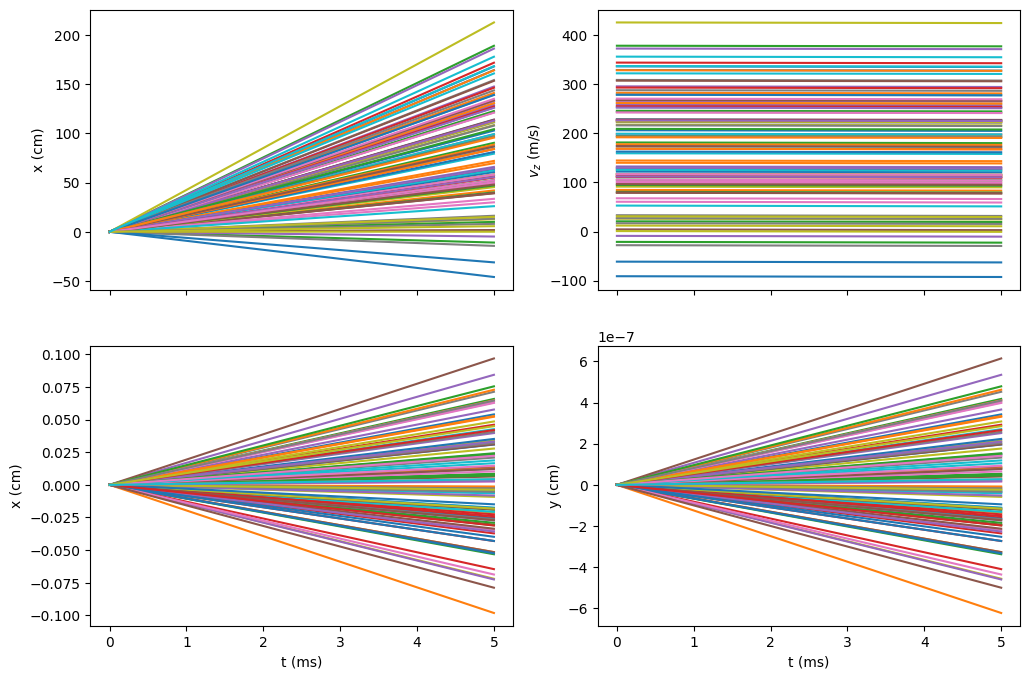

In [ ]:
fig,ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for i in range(len(z_n)):
    ax[0][0].plot(np.array(t_span)*t0*1e3,np.array(z_n[i])*x0)
    ax[0][1].plot(np.array(t_span)*t0*1e3,np.array(vz_n[i])*vc)
    ax[1][0].plot(np.array(t_span)*1e3*t0,np.array(x_n[i]))
    ax[1][1].plot(np.array(t_span)*t0*1e3,np.array(y_n[i])*x0)

ax[1][0].set_xlabel('t (ms)')
ax[1][1].set_xlabel('t (ms)')
ax[0][0].set_ylabel('x (cm)')
ax[0][1].set_ylabel('$v_z$ (m/s)')
ax[1][0].set_ylabel('x (cm)')
ax[1][1].set_ylabel('y (cm)')

In [ ]:
l = 26/x0
c = 0
d = 0
for i in range(len(vz_n)):
    j = vz_n[i]
    if int(j[0]) > 0:
        z_t = z_n[i]
        pos = j[z_t.index(find_nearest_value(z_t,l))]
        if pos < 9.6:
            c+=1
print(c)



28


In [ ]:
det =  np.linspace(-10,-20,100)
capture_efficnecy.index(max(capture_efficnecy))
det[25]*gammalab/1e6

-2417.373737373737